## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('energy_price',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/alexanderdahm/Documents/GitHub/mlfs-book-proj
HopsworksSettings initialized!


In [2]:
# Uninstall the current incompatible version
#!pip uninstall -y hopsworks
#!pip install "hopsworks==4.2.*"

import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.energy_price import util
import os

2026-01-03 19:29:10,883 WARNING: DeprecationWarning: 'parseString' deprecated - use 'parse_string'

2026-01-03 19:29:10,884 WARNING: DeprecationWarning: 'resetCache' deprecated - use 'reset_cache'

2026-01-03 19:29:10,918 WARNING: DeprecationWarning: 'enablePackrat' deprecated - use 'enable_packrat'

2026-01-03 19:29:10,938 WARNING: In /Users/alexanderdahm/miniconda3/envs/aq/lib/python3.10/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle: 'parseString' deprecated - use 'parse_string'
2026-01-03 19:29:10,938 WARNING: In /Users/alexanderdahm/miniconda3/envs/aq/lib/python3.10/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle: 'resetCache' deprecated - use 'reset_cache'


In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today
#today = datetime.datetime.now(datetime.timezone.utc).replace(tzinfo=None) #New


datetime.datetime(2026, 1, 3, 19, 29, 11, 108341)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()


2026-01-03 19:29:11,111 INFO: Initializing external client
2026-01-03 19:29:11,112 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-03 19:29:12,631 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1290388


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="energy_price_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()


2026-01-03 19:29:18,097 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/458044 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/55288 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/124717 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model_energy_price.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model



XGBRegressor(base_score='3.389804E2', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.83s) 
        date  temperature_2m_mean_flasjon  precipitation_sum_flasjon  \
0 2026-01-04                   -20.549999                        0.0   
1 2026-01-05                   -20.000000                        0.0   
2 2026-01-06                   -22.049999                        0.0   
3 2026-01-07                   -14.350000                        0.3   
4 2026-01-08                   -10.850000                        0.2   
5 2026-01-09                    -6.750000                        0.5   

   wind_speed_10m_max_flasjon  wind_direction_10m_dominant_flasjon  \
0                    5.771239                           273.576263   
1                    6.214563                           259.992096   
2                    2.160000                           270.000000   
3                    8.788720                            34.992100   
4                    8.350138                            82

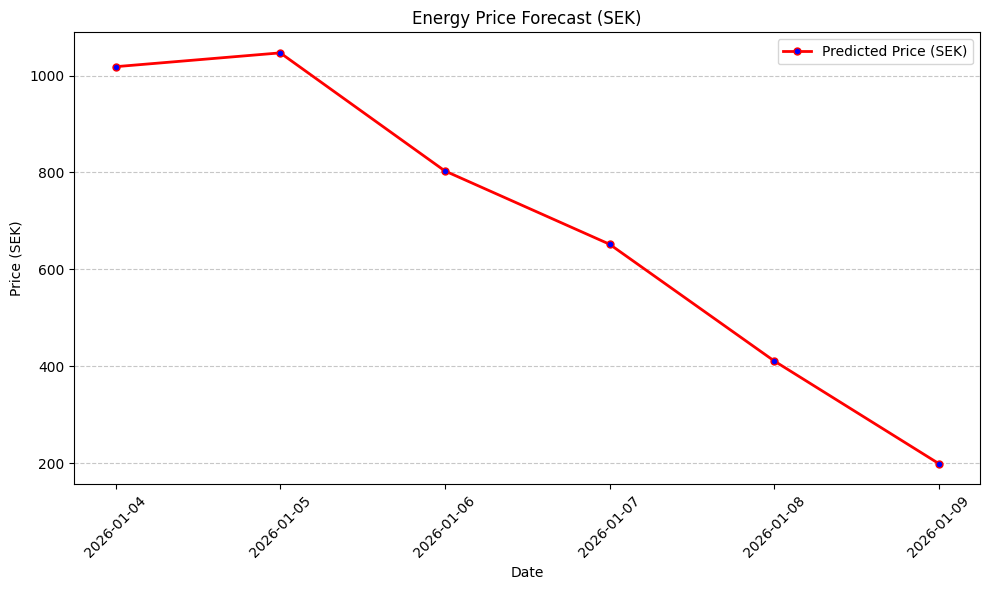

Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:00 | Remaining Time


Launching job: energy_price_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1290388/jobs/named/energy_price_predictions_1_offline_fg_materialization/executions
2026-01-03 19:29:41,640 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2026-01-03 19:29:44,864 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2026-01-03 19:31:27,728 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2026-01-03 19:31:30,945 INFO: Waiting for execution to finish. Current state: FINISHED. Final status: SUCCEEDED
2026-01-03 19:31:31,481 INFO: Waiting for log aggregation to finish.
2026-01-03 19:31:31,483 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.20s) 
2026-01-03 19:31:33,552 WARNING: SettingWithCopyWarning: 
A value is trying to be set

Uploading Dataframe: 100.00% |█| Rows 20/20 | Elapsed Time: 00:00 | Remaining Ti


Launching job: energy_price_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1290388/jobs/named/energy_price_predictions_1_offline_fg_materialization/executions
2026-01-03 19:32:18,337 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2026-01-03 19:32:21,546 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2026-01-03 19:32:24,754 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2026-01-03 19:34:04,867 INFO: Waiting for log aggregation to finish.
2026-01-03 19:34:13,613 INFO: Execution finished successfully.
           date  predicted_sek         sek
516  2025-12-16     361.531219  256.829987
967  2025-12-17     224.221802  265.000000
666  2025-12-18     107.433601   46.369999
650  2025-12-19      40.732754   35.610001
672  2025-12-20      62.529167   25.850000
554  2025-12-21     178.45

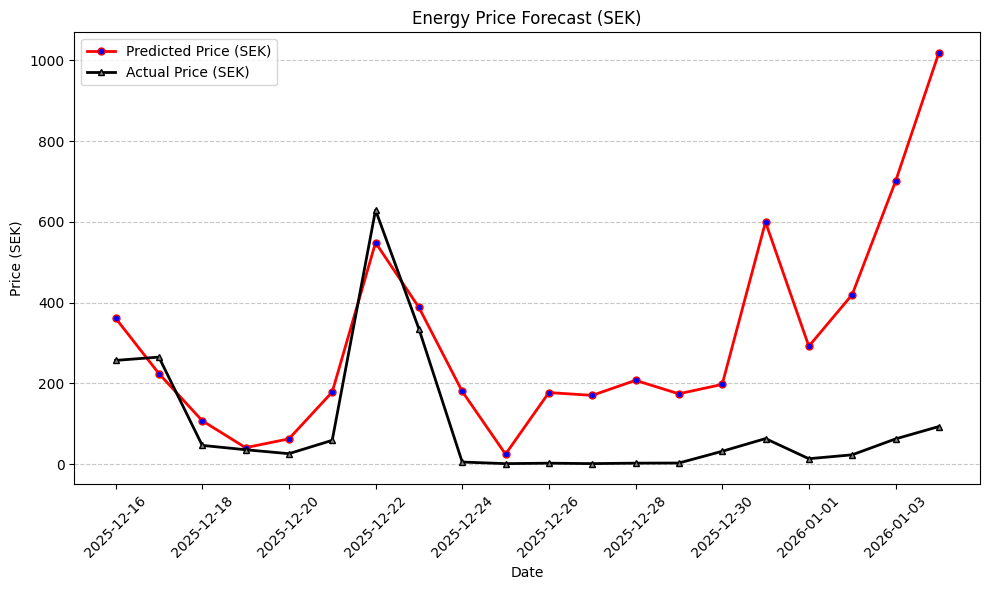

Uploading /Users/alexanderdahm/Documents/GitHub/mlfs-book-proj/docs/air-quality/assets/img/energy_price_foreca…

Uploading /Users/alexanderdahm/Documents/GitHub/mlfs-book-proj/docs/air-quality/assets/img/energy_price_hindca…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1290388/settings/fb/path/Resources/energy_price


In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
energy_price_fg = fs.get_feature_group(
    name='energy_price',
    version=1,
)

# Get batch data for predictions
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data['date'] = pd.to_datetime(batch_data['date'], utc=True).dt.tz_convert(None)
batch_data = batch_data.sort_values('date').reset_index(drop=True)

# Make predictions
batch_data['predicted_sek'] = retrieved_xgboost_model.predict(batch_data[[
    'temperature_2m_mean_flasjon',
    'precipitation_sum_flasjon',
    'wind_speed_10m_max_flasjon',
    'wind_direction_10m_dominant_flasjon',
    'temperature_2m_mean_hudiksvall',
    'precipitation_sum_hudiksvall',
    'wind_speed_10m_max_hudiksvall',
    'wind_direction_10m_dominant_hudiksvall',
    'temperature_2m_mean_ange',
    'precipitation_sum_ange',
    'wind_speed_10m_max_ange',
    'wind_direction_10m_dominant_ange',
    'temperature_2m_mean_solleftea',
    'precipitation_sum_solleftea',
    'wind_speed_10m_max_solleftea',
    'wind_direction_10m_dominant_solleftea',
    'temperature_2m_mean_umea',
    'precipitation_sum_umea',
    'wind_speed_10m_max_umea',
    'wind_direction_10m_dominant_umea',
]])

# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
print(batch_data)

# Plot and save img for predictions
pred_file_path = f"{root_dir}/docs/air-quality/assets/img/energy_price_forecast.png"
plt = util.plot_energy_forecast(batch_data, pred_file_path)
plt.show()

# Insert into the monitoring feature group
monitor_fg = fs.get_or_create_feature_group(
    name='energy_price_predictions',
    description='Energy price prediction monitoring',
    version=1,
    primary_key=['date','days_before_forecast_day'],
    event_time="date",
    stream=False,
    time_travel_format="HUDI"
)

monitor_fg.insert(batch_data, wait=True)

# Load real energy price outcomes
energy_price_df = energy_price_fg.read()
energy_price_df['date'] = pd.to_datetime(energy_price_df['date'], utc=True).dt.tz_convert(None)

outcome_df = energy_price_df[['date', 'sek']]
preds_df = batch_data[['date', 'predicted_sek']]

preds_df['date'] = pd.to_datetime(preds_df['date']).dt.tz_localize(None)
outcome_df['date'] = pd.to_datetime(outcome_df['date']).dt.tz_localize(None)

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
#if len(hindcast_df) == 0:
hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, energy_price_df, monitor_fg, retrieved_xgboost_model)
hindcast_df
print(hindcast_df)

# Generate hindcast plot
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/energy_price_hindcast.png"
plt = util.plot_energy_forecast(hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

# Upload plots to Hopsworks
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/energy_price") == False:
    dataset_api.mkdir("Resources/energy_price")
dataset_api.upload(pred_file_path, f"Resources/energy_price/forecast_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/energy_price/hindcast_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/energy_price")

## 